# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import plotly.express as px
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_curve, auc
from lightgbm import LGBMClassifier
from utils import  *
import skopt
from skopt import BayesSearchCV
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

%matplotlib inline
plt.style.use('fivethirtyeight')

In [ ]:
!pip install scikit-learn==0.23.2

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).


In [6]:
# load in the data
azdias = pd.read_csv('data/azdias.csv')
customers = pd.read_csv('data/customers.csv')
attributes = pd.read_excel('data/attributes.xlsx', column_names = 1)

#drop 3 of the customer columns which are missing in the global population dataset
customers_clean = customers.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis = 1, inplace = True)

C:\Users\tmishinev\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#check for object values within the dataset 
print(cat_check(azdias))

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               5162
OST_WEST_KZ                    2
dtype: int64


In [8]:
# as we can see the there are some X and XX values that should be corrected in the following columns
print(azdias['CAMEO_DEU_2015'].unique())
print(azdias['CAMEO_DEUG_2015'].unique())
print(azdias['CAMEO_INTL_2015'].unique())

[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


EINGEFUEGT_AM is a datetime column and OST_WEST_KZ should be mapped to binary values 
all transpormations are done in feature_transform() in file utils.py

### Missing values

In [9]:
#use the attributes xls file to map the 0,-1,9 values to -1 
azdias = unknown_unify(azdias, attributes)
customers = unknown_unify(customers, attributes)

C:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


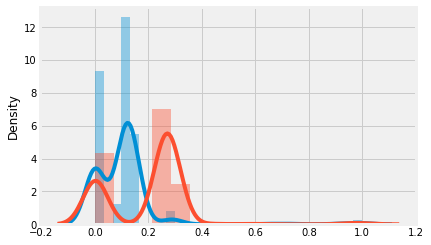

In [10]:
#missing features distribution
sns.distplot(azdias.isnull().sum()/len(azdias))
sns.distplot(customers.isnull().sum()/len(customers))

In [11]:
#display features with more than 30% missing values
missing_values = azdias.isnull().sum()/len(azdias)
azdias[missing_values[missing_values > 0.30].index].head()

,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,EXTSEL992,KK_KUNDENTYP
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,14.0,NaN
3,NaN,NaN,NaN,NaN,31.0,NaN
4,NaN,NaN,NaN,NaN,NaN,1.0


####      ALTER_KIND features mark the age of children. Having a lot of NaN values is normal and dropping the features may result in loosing information. 

In [12]:
#transforming some of the features and removing incorrect values
azdias = feature_transform(azdias)
customers = feature_transform(customers)

Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature


## Part 1: Unsupervised model:

In [13]:
#unsupervised data preprocessing
pipeline_unsup = Pipeline([  ('impute', SimpleImputer(strategy= 'constant', fill_value = -1)),
                             ('scale', StandardScaler()), 
                             ('pca' , PCA()),
                        ])

#fit and transform the sets
azdias_pca = pipeline_unsup.fit_transform(azdias)
customers_pca =  pipeline_unsup.transform(customers)

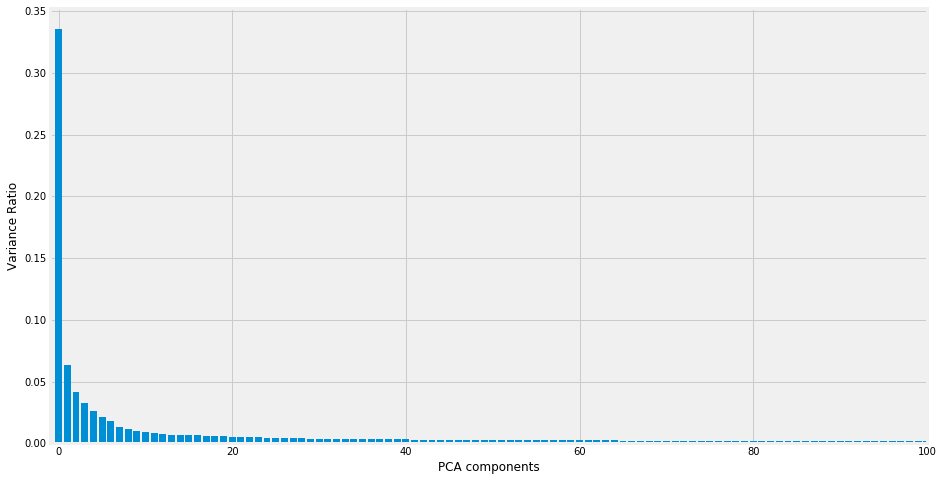

0.8999071544374211

In [25]:
#calculate PCA features to use in the clustering model
fig = plt.figure(figsize = (14,8))
plt.bar(list(range(0, len(pipeline_unsup[2].explained_variance_ratio_))), pipeline_unsup[2].explained_variance_ratio_)
plt.xlabel('PCA components')
plt.ylabel('Variance Ratio')
plt.xlim(-1, 100)
plt.show()

pipeline_unsup[2].explained_variance_ratio_[:130].sum()

In [16]:
#calculate number of clusters for the KMeans++ model:
score = []

for i in range(2,15):
    clt = KMeans(n_clusters = i)
    global_cluster = clt.fit(azdias_pca[:, :130])
    score.append(global_cluster.inertia_)
    print(score[i-2])
    
    

188191341.2686645
173872709.52348864
162819598.04066133
156367110.40607733
151754073.08433107
148195595.1602222
145546420.67683277
143484538.35631755
141831145.2178507
140514632.76236558
139293735.09699157
138277592.73324025
136940701.5433825


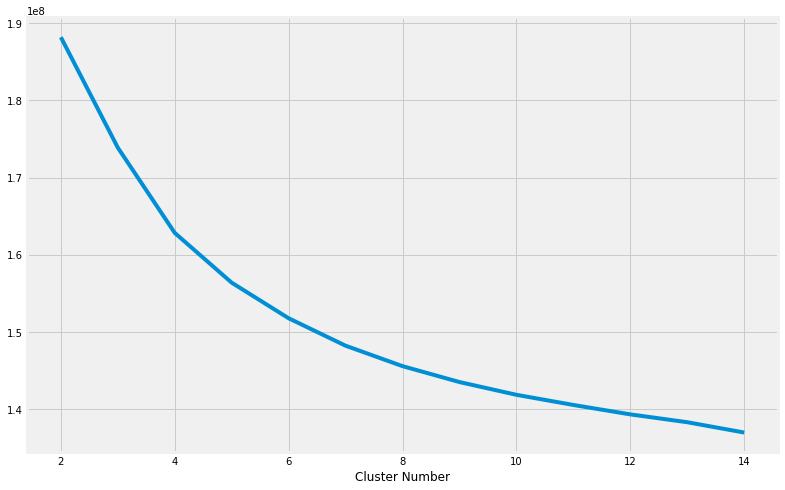

In [19]:
#plow elbow curve
fig = plt.figure(figsize = (12,8))
sns.lineplot(x = list(range(2,15)), y = score)
plt.xlabel('Cluster Number')
plt.show()

In [42]:
#init and fit the Kmeans++ with the desirable number of clusters (10)
clt = KMeans(n_clusters = 8)

azdiaz_cluster = clt.fit(azdias_pca[:, :130])

In [43]:
#predict cluster labels for arvato customerz
customers_cluster = clt.predict(customers_pca[:, :130])

C:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


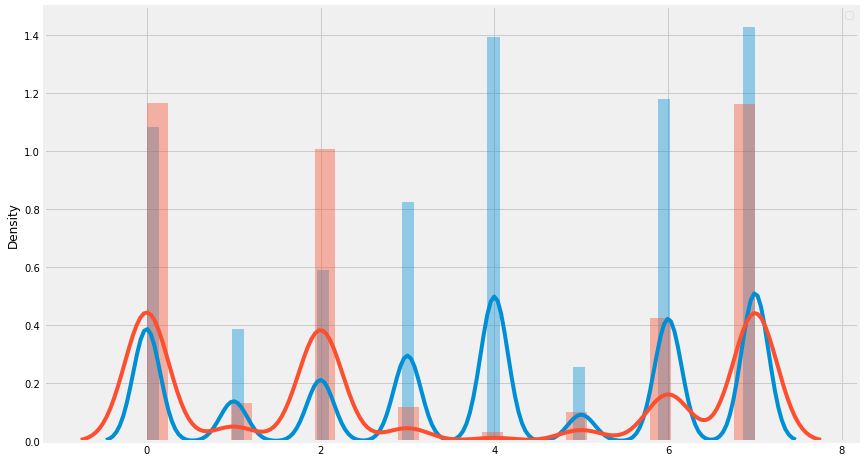

In [44]:
#plot the distribution between azdias and customers data inside the clusters
fig = plt.figure(figsize = (13,8))
sns.distplot(azdiaz_cluster.labels_)
sns.distplot(customers_cluster)
plt.legend()
plt.show()

#### Let's take a look at the features between the two most different clusters

### Identify important feature differences between the clusters

In [51]:
azdias_clst = azdias
azdias_clst['Cluster'] = azdiaz_cluster.labels_

customers_clst = customers
customers_clst['Cluster'] = customers_cluster

azdias_clst = azdias_clst[azdias_clst['Cluster'] == 4]
customers_clst = customers_clst[customers_clst['Cluster'] == 0]

#get mean difference between features
diff = pd.DataFrame({'Cluster_4': azdias_clst.mean(), 'Cluster_0': customers_clst.mean()})
diff['delta'] = abs(diff['Cluster_4'] - diff['Cluster_0'])
diff.head(20).sort_values(['delta'], ascending = False)

,Cluster_4,Cluster_0,delta
CAMEO_INTL_2015,40.167221,25.234767,14.932454
ANZ_HAUSHALTE_AKTIV,10.640254,1.990905,8.649349
ANZ_STATISTISCHE_HAUSHALTE,9.529157,1.871244,7.657913
ALTERSKATEGORIE_FEIN,17.162992,11.488055,5.674937
AKT_DAT_KL,6.998706,1.465824,5.532882
ALTER_HH,9.872729,14.180602,4.307874
CAMEO_DEUG_2015,6.443268,3.644613,2.798656
ANZ_PERSONEN,1.303254,3.164209,1.860955
AGER_TYP,-0.980267,0.727800,1.708067
ALTER_KIND1,11.708493,12.537226,0.828733


##### CAMEO_DEUG_2015: Customers are more likely to be established middle class against Cluster 3 values : low-consumption middleclass.

##### CAMEO_INTL_2015: Prosperous households are more likely to be customers.

##### ANZ_PERSONEN: Households with more adult people use the company's products.

##### ALTER_HH: The main age within the households of customers is lower than the underrepresented cluster.

## Part 2: Supervised Learning Model


## Load and clean the train and test dataset

C:\Users\tmishinev\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


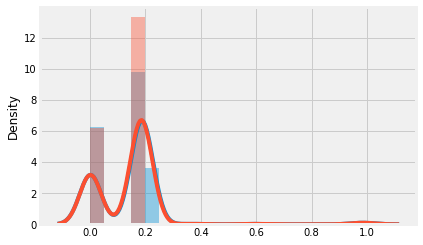

In [2]:
mailout_train = pd.read_csv('data/mail_train.csv')
mailout_test = pd.read_csv('data/mail_test.csv')


#most of the features has less than 30% missing values similar to azdias and customers datasets
sns.distplot(mailout_train.isnull().sum()/len(mailout_train))
sns.distplot(mailout_test.isnull().sum()/len(mailout_test))

In [3]:
#process load data
attributes = pd.read_excel('data/attributes.xlsx', column_names = 1)

#train data
mailout_train = unknown_unify(mailout_train, attributes)
X = feature_transform(mailout_train)

#test data
mailout_test = unknown_unify(mailout_test, attributes)
X_sub = feature_transform(mailout_test)

#----!

y = X['RESPONSE']
X.drop(['RESPONSE'], axis = 1, inplace = True)

print(X.shape, X_sub.shape)

Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
(42962, 364) (42833, 364)


0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64


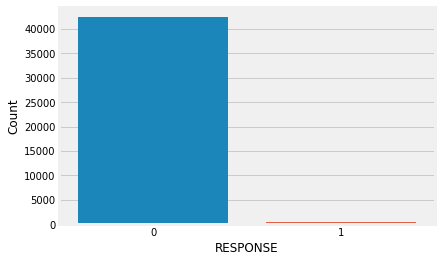

In [4]:
sns.barplot(x = y.value_counts().index, y = y.value_counts())
plt.xlabel('RESPONSE')
plt.ylabel('Count')
print(y.value_counts()/y.count())


### Test the initial models for overall performance based on the competition metri ROC_AUC

C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


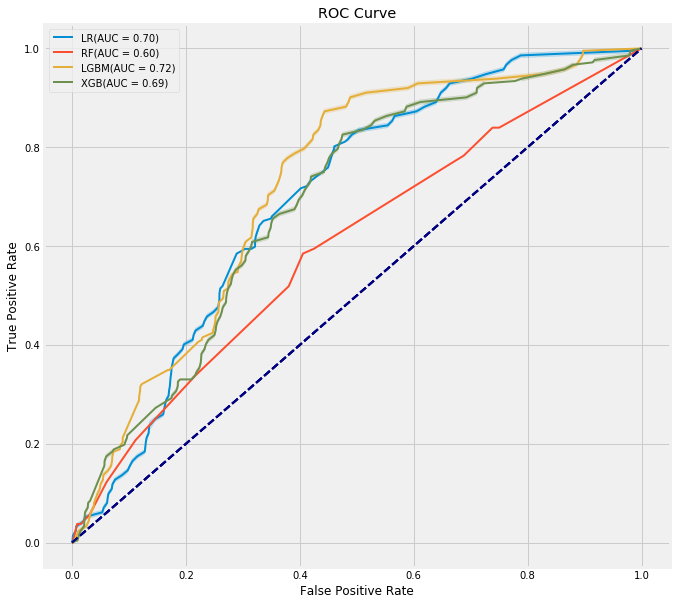

In [5]:
#create list of models with default hyerparameters using models with capability for probabilistic prediction
model_list = {'LR':LogisticRegression(), 'RF' : RandomForestClassifier(),'LGBM':  LGBMClassifier(), 'XGB':  XGBClassifier()}

#loop through the models and evaluate basic performance
fig = plt.figure(figsize = (10,10))
for keys in model_list:
    #plot series
    pipeline = Pipeline([('impute', SimpleImputer(strategy= 'constant', fill_value = -1)),('scale', StandardScaler()),  ('clf', model_list[keys])])
    plot_roc(pipeline,X, y, keys)

plt.show()

### Results:

It's clear that with the default parameters LGBMClassifier gives the highest results. After some parameter tuning and submission to the competition actually XGB gave higher scores so I will continue with BayesianOptimization of the algorithm

In [ ]:
pipeline = Pipeline([('impute', SimpleImputer(strategy= 'constant', fill_value = -1)), 
                     ('clf', XGBClassifier())
                    ])

#### Bayesian Optimization of XGB hyperparameters. 

Using 5 fold StratifiedKFold to evaluate each step. Here I use only 10 steps for example and try to keep the notebook as clean as possible.

In [52]:
ITERATIONS = 10
SEED = 42

bayes_cv_tuner_xg = BayesSearchCV(
    estimator = pipeline,
    search_spaces = {
        'clf__learning_rate': (0.001, 0.9, 'log-uniform'),
        'clf__max_depth': (2, 10),
        'clf__min_child_weight': (1, 10),
        'clf__gamma': (0.0, 1.0, 'uniform'),
        'clf__subsample': (0.5, 1.0, 'uniform'),
        'clf__colsample_bytree': (0.5, 1.0, 'uniform'),
        'clf__reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'clf__n_estimators': (50, 500),
        'clf__scale_pos_weight': (1,90)
        
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state= SEED
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = np.random.RandomState(50)
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format },
    all_models = pd.DataFrame(bayes_cv_tuner_xg.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_xg.best_params_)
    
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_xg.best_score_, 4),
        bayes_cv_tuner_xg.best_params_
    ))    
    
    # Save all model results
    clf_name = bayes_cv_tuner_xg.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")
    
%time
result_xg = bayes_cv_tuner_xg.fit(X, y, callback=status_print)

Wall time: 0 ns
Model #1
Best ROC-AUC: 0.7066
Best params: OrderedDict([('clf__colsample_bytree', 0.9304947779168935), ('clf__gamma', 0.451216162792089), ('clf__learning_rate', 0.030102623541718464), ('clf__max_depth', 9), ('clf__min_child_weight', 1), ('clf__n_estimators', 241), ('clf__reg_alpha', 0.014156357168414447), ('clf__scale_pos_weight', 35), ('clf__subsample', 0.5036995347750647)])

Model #2
Best ROC-AUC: 0.7066
Best params: OrderedDict([('clf__colsample_bytree', 0.9304947779168935), ('clf__gamma', 0.451216162792089), ('clf__learning_rate', 0.030102623541718464), ('clf__max_depth', 9), ('clf__min_child_weight', 1), ('clf__n_estimators', 241), ('clf__reg_alpha', 0.014156357168414447), ('clf__scale_pos_weight', 35), ('clf__subsample', 0.5036995347750647)])

Model #3
Best ROC-AUC: 0.7066
Best params: OrderedDict([('clf__colsample_bytree', 0.9304947779168935), ('clf__gamma', 0.451216162792089), ('clf__learning_rate', 0.030102623541718464), ('clf__max_depth', 9), ('clf__min_child_

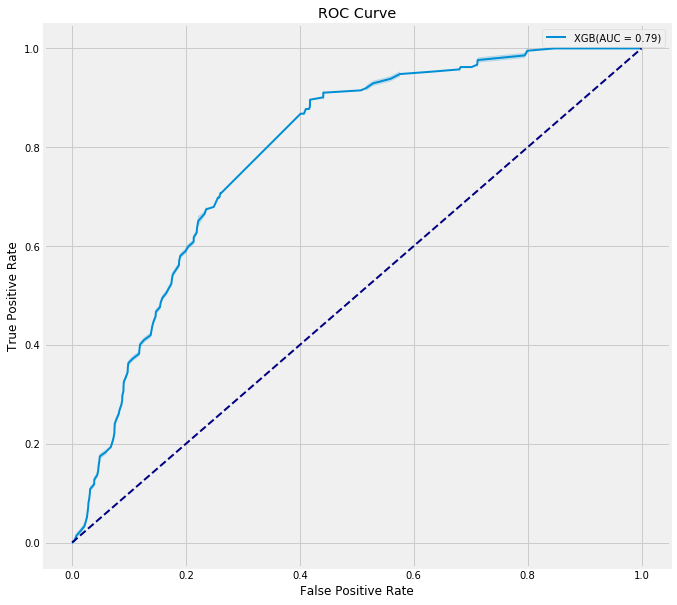

In [54]:
#optimized algorithm
parameters= dict([('colsample_bytree', 0.6888348010130712), ('gamma', 0.43702345115978325), ('learning_rate', 0.0030871248366675184), ('max_depth', 3), ('min_child_weight', 5), ('n_estimators', 376), ('reg_alpha', 0.9682055105813826), ('scale_pos_weight', 86), ('subsample', 0.9162583886152913)])


pipeline = Pipeline([('impute', SimpleImputer(strategy= 'constant', fill_value = -1)), 
                     ('clf', XGBClassifier(**parameters))
                    ])

fig
fig1 = plt.figure(figsize = (10,10))
plot_roc(pipeline,X, y, 'XGB')

## Part 3: Kaggle Competition (4th position in the leaderboard)

#### At the end highest result was achieved after using the model with the first 200 features based on the feature importances of the XGB. Maybe it's better to keep the slightly lower score based on all features because the test at Kaggle is done only at 30% of the test data. Using all the features should generalize better and probably will give better results on new data.

In [ ]:
num_features = 200

#get the feature importances DataFrame and plot the barchart
model_fi = XGBClassifier( verbose = False).fit( X, y)
fi = pd.DataFrame({'features':X.columns, 'importance' : model_fi.feature_importances_/ model_fi.feature_importances_.sum()}).sort_values(['importance'], ascending = False)
fig = px.bar(x = fi['features'], y = fi['importance'])
fig.show()

#reduce the ftrain and test data based on the important features
X_reduced = X[fi['features'].head(num_features).to_list()]
X_sub_reduced = X_sub[fi['features'].head(num_features).to_list()]


In [ ]:
#use the dictionaty with optimized parameters result of the BayesianOptimization
model = XGBClassifier(**parameters)

#predefined funciton for trainings and exporting the final model
predict_sub(X_reduced, y, model, X_sub_reduced)